# Differentially Private Histograms

## Plotting the distribution of ages in `Adult`

In [1]:
import numpy as np
from diffprivlib import tools as dp
import matplotlib.pyplot as plt

We first read in the list of ages in the Adult UCI dataset (the first column).

In [2]:
ages_adult = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=0, delimiter=", ")

Using Numpy's native `histogram` function, we can find the distribution of ages, as determined by ten equally-spaced bins calculated by `histogram`.

In [3]:
hist, bins = np.histogram(ages_adult)
hist = hist / hist.sum()

Using `matplotlib.pyplot`, we can plot a barchart of the histogram distribution.

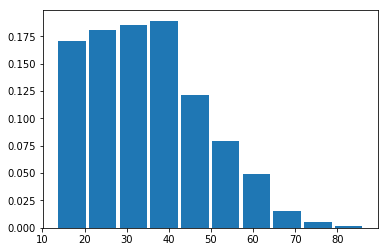

In [4]:
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.show()

## Differentially private histograms

Using `diffprivlib`, we can calculate a differentially private version of the histogram. For this example, we use the default settings:
- `epsilon` is 1.0
- `range` is not specified, so is calculated by the function on-the-fly. This throws a warning, as it leaks privacy about the data (from `dp_bins`, we know that there are people in the dataset aged 17 and 90).

.../site-packages/diffprivlib/tools/histograms.py:131: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  "specified independently of the data (i.e., using domain knowledge).", PrivacyLeakWarning)


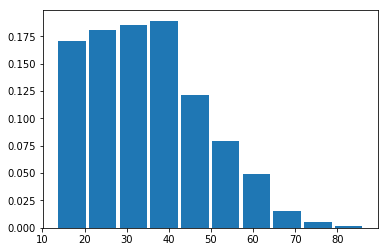

In [5]:
dp_hist, dp_bins = dp.histogram(ages_adult)
dp_hist = dp_hist / dp_hist.sum()

plt.bar(dp_bins[:-1], dp_hist, width=(dp_bins[1] - dp_bins[0]) * 0.9)
plt.show()

**Privacy Leak:** In this setting, we know for sure that at least one person in the dataset is aged 17, and another is aged 90.

In [6]:
dp_bins[0], dp_bins[-1]

(17.0, 90.0)

**Mirroring the behaviour of `np.histogram`:** We can see that the bins returned by `diffprivlib.tools.histogram` are identical to those given by `numpy.histogram`.

In [7]:
np.all(dp_bins == bins)

True

**Error:** We can see very little difference in the values of the histgram. In fact, we see an aggregate absolute error across all bins of the order of 0.01%. This is expected, due to the large size of the dataset (`n=48842`). 

In [8]:
print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())

Total histogram error: 0.000380


**Effect of `epsilon`:** If we decrease `epsilon` (i.e. **increase** the privacy guarantee), the error will increase.

In [9]:
dp_hist, dp_bins = dp.histogram(ages_adult, epsilon=0.001)
dp_hist = dp_hist / dp_hist.sum()

print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())

Total histogram error: 0.242242


.../site-packages/diffprivlib/tools/histograms.py:131: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  "specified independently of the data (i.e., using domain knowledge).", PrivacyLeakWarning)


## Deciding on the `range` parameter

We know from the [dataset description](https://archive.ics.uci.edu/ml/datasets/adult) that everyone in the dataset is at least 17 years of age. We don't know off-hand what the upper bound is, so for this example we'll set the upper bound to `100`. As of 2019, less than 0.005% of the world's population is [aged over 100](https://en.wikipedia.org/wiki/Centenarian), so this is an appropriate simplification. Values in the dataset above 100 will be excluded from calculations.

An `epsilon` of 0.1 still preserves the broad structure of the histogram.

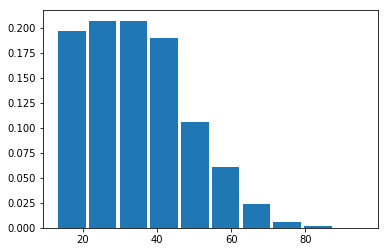

In [10]:
dp_hist2, dp_bins2 = dp.histogram(ages_adult, epsilon=0.1, range=(17, 100))
dp_hist2 = dp_hist2 / dp_hist2.sum()

plt.bar(dp_bins2[:-1], dp_hist2, width=(dp_bins2[1] - dp_bins2[0]) * 0.9)
plt.show()

## Error for smaller datasets

Let's repeate the first experiments above with a smaller dataset, this time the [Cleveland heart disease dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) from the UCI Repository. This dataset has 303 samples, a small fractin of the Adult dataset processed previously.

In [11]:
ages_heart = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                        usecols=0, delimiter=",")

We first find the histogram distribution using `numpy.histogram`.

In [12]:
heart_hist, heart_bins = np.histogram(ages_heart)
heart_hist = heart_hist / heart_hist.sum()

And then find the histogram distribution using `diffprivlib.histogram`, using the defaults as before (with the accompanying warning).

In [13]:
dp_heart_hist, dp_heart_bins = dp.histogram(ages_heart)
dp_heart_hist = dp_heart_hist / dp_heart_hist.sum()

.../site-packages/diffprivlib/tools/histograms.py:131: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  "specified independently of the data (i.e., using domain knowledge).", PrivacyLeakWarning)


And double-check that the bins are the same.

In [14]:
np.all(heart_bins == dp_heart_bins)

True

We then see that the error this time is 3%, a 100-fold increase in error.

In [15]:
print("Total histogram error: %f" % np.abs(heart_hist - dp_heart_hist).sum())

Total histogram error: 0.031932


## Mirroring Numpy's behaviour

We can evaluate `diffprivlib.models.histogram` without any privacy by setting `epsilon = float("inf")`. This should give the exact same result as running `numpy.histogram`.

In [16]:
heart_hist, _ = np.histogram(ages_heart)
dp_heart_hist, _ = dp.histogram(ages_heart, epsilon=float("inf"))

np.all(heart_hist == dp_heart_hist)

.../site-packages/diffprivlib/tools/histograms.py:131: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  "specified independently of the data (i.e., using domain knowledge).", PrivacyLeakWarning)


True